# 필요한 라이브러리 및 환경 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
import glob
import pandas as pd 
from natsort import natsorted
import csv
import shutil

## 동영상들을 입력값으로 사용해 이미지 프레임화후, 각 폴더로 저장함

In [3]:
dirpath = '/content/drive/MyDrive/ttproject/tiktok_video_test'

for filename in os.listdir(dirpath):
    if filename.endswith(".mp4"):
        filepath = os.path.join(dirpath, filename)

        video = cv2.VideoCapture(filepath)

        if not video.isOpened():
            print("Could not open:", filepath)
            continue

        # 비디오 파일 정보 출력
        length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = video.get(cv2.CAP_PROP_FPS)

        print("Processing video: ", filename)
        print("length:", length)
        print("width:", width)
        print("height:", height)
        print("fps:", fps)

        # 디렉토리 생성
        directory = os.path.splitext(filepath)[0]  # 동영상 파일명에서 확장자를 제외한 부분을 디렉토리명으로 사용
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print('Error: Creating directory -', directory)
            continue

        count = 0
        while video.isOpened():
            ret, image = video.read()
            if not ret:
                break
            if int(video.get(1)) % int(fps) == 0:  # 1초마다 이미지 추출
                cv2.imwrite(directory + "/frame%d.jpg" % count, image)
                print('Saved frame number:', int(video.get(1)))
                count += 1

        video.release()


Processing video:  Normal009.mp4
length: 416
width: 576
height: 1024
fps: 30.0
Saved frame number: 30
Saved frame number: 60
Saved frame number: 90
Saved frame number: 120
Saved frame number: 150
Saved frame number: 180
Saved frame number: 210
Saved frame number: 240
Saved frame number: 270
Saved frame number: 300
Saved frame number: 330
Saved frame number: 360
Saved frame number: 390
Processing video:  Normal004.mp4
length: 235
width: 576
height: 1024
fps: 30.0
Saved frame number: 30
Saved frame number: 60
Saved frame number: 90
Saved frame number: 120
Saved frame number: 150
Saved frame number: 180
Saved frame number: 210
Processing video:  Normal012.mp4
length: 450
width: 576
height: 1024
fps: 30.0
Saved frame number: 30
Saved frame number: 60
Saved frame number: 90
Saved frame number: 120
Saved frame number: 150
Saved frame number: 180
Saved frame number: 210
Saved frame number: 240
Saved frame number: 270
Saved frame number: 300
Saved frame number: 330
Saved frame number: 360
Save

In [4]:
image_size = (180, 180)
channels = 3
#본 모델에서 180, 180 3채널로 고정시켰기 때문에 고정변수입니다 이미지사이즈

In [5]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 모델 불러오기, 분류 class 설정

In [6]:
exposure_model = load_model('/content/drive/MyDrive/newVGG16(노출비노출).h5')
violence_model = load_model('/content/drive/MyDrive/newVGG16(폭력비폭력).h5')
relationship_model = load_model('/content/drive/MyDrive/newVGG16(관계비관계).h5')

In [7]:
naked_classes = ['Naked', 'Non-Naked'] 
violence_classes = ['Non-Violence', 'Violence'] 
sexual_classes = ['Sexual', 'Non-Sexual']     

In [8]:
def preprocess_image(image):
  image = cv2.resize(image, image_size)
  image = image.astype('float32') / 255.0
  return image

In [9]:
def classify_image(image):
    preprocessed_image = preprocess_image(image)
    naked_prediction = exposure_model.predict(np.expand_dims(preprocessed_image, axis=0))[0]
    violence_prediction = violence_model.predict(np.expand_dims(preprocessed_image, axis=0))[0]
    sexual_prediction = relationship_model.predict(np.expand_dims(preprocessed_image, axis=0))[0]

    # 각 범주별로 해당 확률 이상일 경우, 해당 클래스를 반환, 그렇지 않으면 'Uncertain' 반환
    naked_class = naked_classes[np.argmax(naked_prediction)] if np.max(naked_prediction) > 0.9 else 'Uncertain'
    violence_class = violence_classes[np.argmax(violence_prediction)] if np.max(violence_prediction) > 0.85 else 'Uncertain'
    sexual_class = sexual_classes[np.argmax(sexual_prediction)] if np.max(sexual_prediction) > 0.8 else 'Uncertain'

    return naked_class, violence_class, sexual_class

## 폴더 전체 분류 테스트

In [10]:
# 틱톡 전체 영상 root 디렉토리
root_path = '/content/drive/MyDrive/ttproject/tiktok_video_test'
folder_df = pd.DataFrame(columns=["폴더명", "유해/비유해 예측", "노출 예측", "폭력 예측", "관계 예측"])

for root, dirs, files in os.walk(root_path):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        folder_name = os.path.basename(folder_path)
        filenames = natsorted(os.listdir(folder_path))

        frame_df = pd.DataFrame({"filename": filenames})
        frame_df["path"] = frame_df["filename"].apply(lambda x: os.path.join(folder_path, x))
        frame_df[["노출", "폭력", "관계"]] = frame_df["path"].apply(lambda x: pd.Series(classify_image(cv2.imread(x))))
        frame_df = frame_df.drop(columns=["path"])

        is_harmful = (frame_df['노출'] == 'Naked').sum() > len(frame_df)*0.15 or (frame_df['폭력'] == 'Violence').sum() > len(frame_df)*0.15 or (frame_df['관계'] == 'Sexual').sum() > len(frame_df)*0.15
        folder_df = folder_df.append({
            "폴더명": folder_name,
            "유해/비유해 예측": "harmful" if is_harmful else "unharmful",
            "노출 예측": "Naked" if (frame_df['노출'] == 'Naked').sum() > len(frame_df)*0.15 else "Non-Naked",
            "폭력 예측": "Violence" if (frame_df['폭력'] == 'Violence').sum() > len(frame_df)*0.15 else "Non-Violence",
            "관계 예측": "Sexual" if (frame_df['관계'] == 'Sexual').sum() > len(frame_df)*0.15 else "Non-Sexual"
        }, ignore_index=True)

folder_df = folder_df.sort_values("폴더명", ascending=True).reset_index(drop=True)
folder_df

1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 17ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 21ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 29ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 21ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 29ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 30ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 21ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 28ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 17ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 30ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 28ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 17ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 29ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 22ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 18ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 21ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 20ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


1/1 [==============================] - 0s 19ms/step


<ipython-input-10-0191f2264deb>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folder_df = folder_df.append({


,폴더명,유해/비유해 예측,노출 예측,폭력 예측,관계 예측
0,Naked001,harmful,Naked,Non-Violence,Sexual
1,Naked002,harmful,Non-Naked,Violence,Sexual
2,Naked003,harmful,Non-Naked,Violence,Sexual
3,Naked004,harmful,Naked,Non-Violence,Sexual
4,Naked005,harmful,Naked,Non-Violence,Non-Sexual
...,...,...,...,...,...
95,Violence006,harmful,Non-Naked,Non-Violence,Sexual
96,Violence007,harmful,Non-Naked,Violence,Non-Sexual
97,Violence008,harmful,Non-Naked,Violence,Sexual
98,Violence009,harmful,Non-Naked,Violence,Non-Sexual


### 각 동영상이 유해하다고 예측 될 경우, blind 폴더로 이동 해, 그 경로를 저장함

In [11]:
import csv
import shutil

# 입력 경로 : 전체 영상들이 들어있는 상위 폴더
folder_path = '/content/drive/MyDrive/ttproject/tiktok_video_test'

# blind 폴더 경로
output_folder = '/content/drive/MyDrive/ttproject/blind'

for file_name in os.listdir(folder_path):
    if any((folder_df['폴더명'] == file_name) & (folder_df['유해/비유해 예측'] == 'harmful')):
        jpg_file_path = os.path.join(folder_path, file_name)
        shutil.move(jpg_file_path, os.path.join(output_folder, file_name))
        # + csv 파일 연동 - 영상-정보 mapping - log 같이 넘어가도록

        # blind처리 된 폴더 경로 excel에 연결
        path = output_folder + '/'+file_name
        folder_df.loc[folder_df['폴더명'] == file_name, 'blind 경로'] = os.path.join(output_folder, file_name)
    else:
        pass

folder_df

,폴더명,유해/비유해 예측,노출 예측,폭력 예측,관계 예측,blind 경로
0,Naked001,harmful,Naked,Non-Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Naked001
1,Naked002,harmful,Non-Naked,Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Naked002
2,Naked003,harmful,Non-Naked,Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Naked003
3,Naked004,harmful,Naked,Non-Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Naked004
4,Naked005,harmful,Naked,Non-Violence,Non-Sexual,/content/drive/MyDrive/ttproject/blind/Naked005
...,...,...,...,...,...,...
95,Violence006,harmful,Non-Naked,Non-Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...
96,Violence007,harmful,Non-Naked,Violence,Non-Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...
97,Violence008,harmful,Non-Naked,Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...
98,Violence009,harmful,Non-Naked,Violence,Non-Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...


## blind 경로 + 예측값 포함된 csv 파일 저장

판단 위해 실제 유해/비유해 여부가 작성되어 있는 csv 파일에 예측 값을 추가함 
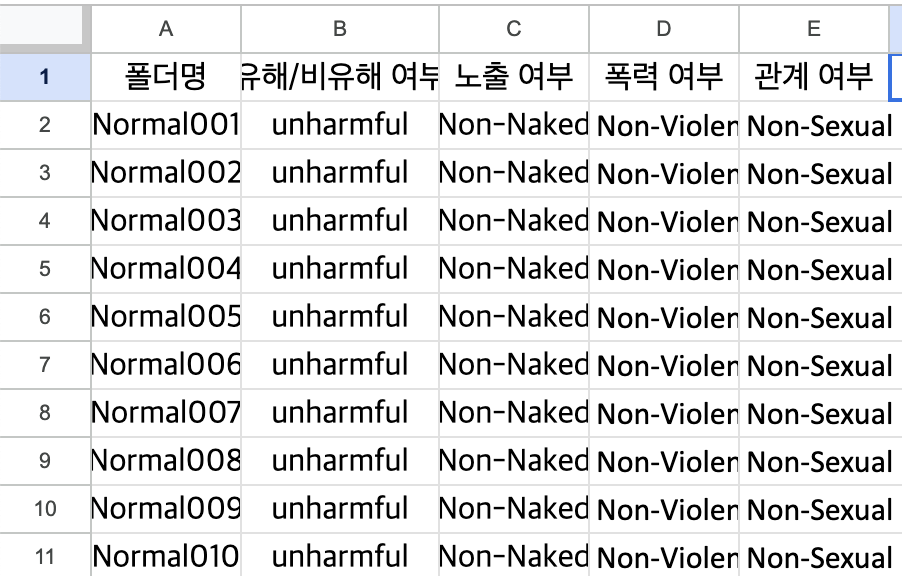


In [12]:
output_df = pd.read_excel('/content/drive/MyDrive/ttproject/필터링결과표.xlsx')
df_A = pd.DataFrame(output_df, columns=output_df.keys())
df_B = pd.DataFrame(folder_df, columns=folder_df.keys())

# 위에 결과 나오면 폴더명을 키값으로 아래 output_df에 붙여넣기 하면 끄읏
result = pd.merge(df_A, df_B, on="폴더명", how="left")
result

,폴더명,유해/비유해 여부,노출 여부,폭력 여부,관계 여부,유해/비유해 예측,노출 예측,폭력 예측,관계 예측,blind 경로
0,Normal001,unharmful,Non-Naked,Non-Violence,Non-Sexual,unharmful,Non-Naked,Non-Violence,Non-Sexual,NaN
1,Normal002,unharmful,Non-Naked,Non-Violence,Non-Sexual,harmful,Non-Naked,Non-Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Normal002
2,Normal003,unharmful,Non-Naked,Non-Violence,Non-Sexual,unharmful,Non-Naked,Non-Violence,Non-Sexual,NaN
3,Normal004,unharmful,Non-Naked,Non-Violence,Non-Sexual,unharmful,Non-Naked,Non-Violence,Non-Sexual,NaN
4,Normal005,unharmful,Non-Naked,Non-Violence,Non-Sexual,unharmful,Non-Naked,Non-Violence,Non-Sexual,NaN
...,...,...,...,...,...,...,...,...,...,...
95,Violence006,harmful,Non-Naked,Violence,Non-Sexual,harmful,Non-Naked,Non-Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...
96,Violence007,harmful,Non-Naked,Violence,Non-Sexual,harmful,Non-Naked,Violence,Non-Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...
97,Violence008,harmful,Non-Naked,Violence,Non-Sexual,harmful,Non-Naked,Violence,Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...
98,Violence009,harmful,Non-Naked,Violence,Non-Sexual,harmful,Non-Naked,Violence,Non-Sexual,/content/drive/MyDrive/ttproject/blind/Violenc...


In [13]:
result.to_excel('/content/drive/MyDrive/ttproject/results.xlsx', index=False)